In [1]:
import os
import shutil
import time
from tqdm import tqdm
from copy import deepcopy
from itertools import product

import random
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

from neuroptimiser import NeurOptimiser
from ioh import get_problem

width = 6.5  # IEEE double-column width
height = width * 0.618  # Adjust the aspect ratio
res_dpi = 333

root_figures = "./figures/"

plt.style.context('paper')
sns.set_style("ticks")
plt.rcParams['font.family']         = 'serif'
plt.rcParams['axes.labelsize']      = 11
plt.rcParams['xtick.labelsize']     = 11
plt.rcParams['ytick.labelsize']     = 11
plt.rcParams['legend.fontsize']     = 11
plt.rcParams['axes.grid']           = False
plt.rcParams['axes.spines.top']     = True
plt.rcParams['axes.spines.right']   = True
plt.rcParams['axes.edgecolor']      = 'black'
plt.rcParams['xtick.color']         = 'black'
plt.rcParams['ytick.color']         = 'black'
plt.rcParams['axes.labelcolor']     = 'black'

if shutil.which("pdflatex") is not None:
    plt.rcParams['text.usetex']         = True
    plt.rcParams['font.serif']          = ['Computer Modern Roman']
else:
    plt.rcParams['text.usetex']         = False

def save_this(fig, _in=""):
    if is_saving:
        os.makedirs(f"{root_figures}/" + _in, exist_ok=True)
        fig.savefig(root_figures + _in + "/" + prefix_filename + ".png", transparent=True, dpi=res_dpi, bbox_inches="tight")
    else:
        plt.show()

In [2]:
is_saving       = True
num_steps       = 100
problem_id      = 1
problem_ins     = 1
num_dimensions  = 2
num_agents      = 30
num_neighbours  = 10

neuropt_name    = "neuropt-LinDiff-c2r"
neuropt_custom_params = [
    {"name": "linear", "spk_cond": "l2", "hs_operator": "differential", "hs_variant": "current-to-rand"},
]

plt.close()

In [3]:
default_core_params = dict(
    alpha       = 1.0,
    dt          = 0.01,
    max_steps   = num_steps,
    noise_std   = (0.0, 0.3),
    ref_mode    = "pg",
    is_bounded  = True,
    name        = "linear",
    coeffs      = "random",
    approx      = "rk4",
    thr_mode    = "diff_pg",
    thr_alpha   = 2.0,
    thr_min     = 1e-6,
    thr_max     = 1.0,
    thr_k       = 0.05,
    spk_cond    = "fixed",
    spk_alpha   = 0.25,
    hs_operator = "fixed",
    hs_variant  = "current-to-rand",
)

if neuropt_custom_params is None:
    neuropt_custom_params = [{}]

core_params = []
for i in range(num_agents):
    p = deepcopy(default_core_params)
    override = neuropt_custom_params[i % len(neuropt_custom_params)]
    p.update(override)
    core_params.append(p)

config_params = dict(
    num_iterations  = num_steps,
    num_agents      = num_agents,
    spiking_core    = "TwoDimSpikingCore",
    num_neighbours  = num_neighbours,
    neuron_topology = "2dr",
    unit_topology   = "random",
)

prefix_filename = (f"{neuropt_name}_"
                   f"{problem_id}p_"
                   f"{problem_ins}i_"
                   f"{num_dimensions}d_"
                   f"{num_steps}s_"
                   f"{num_agents}u")

if is_saving:
    print(f"prefix_filename: '{prefix_filename}'")

prefix_filename: 'neuropt-LinDiff-c2r_1p_1i_2d_100s_30u'


In [4]:
problem = get_problem(fid=problem_id,
                      instance=problem_ins,
                      dimension=num_dimensions,
                      )
problem.reset()
# problem.num_params = config_params["num_dimensions"]
print(problem)

<RealSingleObjectiveProblem 1. Sphere (iid=1 dim=2)>


In [5]:
seed = 42
random.seed(seed)
np.random.seed(seed)

optimiser = NeurOptimiser(config_params, core_params)

optimiser.solve(problem, debug_mode=True)

[neuropt:log] Debug mode is enabled. Monitoring will be activated.
[neuropt:log] Parameters are set up.
[neuropt:log] Initial positions and topologies are set up.
[neuropt:log] Tensor contraction layer, neighbourhood manager, and high-level selection unit are created.
[neuropt:log] Population of nheuristic units is created.
[neuropt:log] Connections between nheuristic units and auxiliary processes are established.
[neuropt:log] Monitors are set up.
[neuropt:log] Starting simulation with 100 iterations...
... step: 0, best fitness: 81.21773529052734
... step: 10, best fitness: 79.96651458740234
... step: 20, best fitness: 79.64804077148438
... step: 30, best fitness: 79.51382446289062
... step: 40, best fitness: 79.49010467529297
... step: 50, best fitness: 79.49010467529297
... step: 60, best fitness: 79.49010467529297
... step: 70, best fitness: 79.49010467529297
... step: 80, best fitness: 79.49010467529297
... step: 90, best fitness: 79.49010467529297
... step: 99, best fitness: 79.

(array([ 0.15866082, -1.12157352]), array([79.49010468]))

In [6]:
fp = optimiser.results["fp"]
fg = optimiser.results["fg"]

efp = np.abs(np.array(fp) - problem.optimum.y)
efg = np.abs(np.array(fg) - problem.optimum.y)

positions = np.array(optimiser.results["p"])
best_position = np.array(optimiser.results["g"])

v1 = np.array(optimiser.results["v1"])
v2 = np.array(optimiser.results["v2"])

print("v1: ", v1.min(), v1.max())
print("v2: ", v2.min(), v2.max())

spikes = np.array(optimiser.results["s"]).astype(int)

print(efg[-1])

v1:  -1.4054041756976423 1.184139758348465
v2:  -1.0351252160121573 1.1930569106786073
[0.01010468]


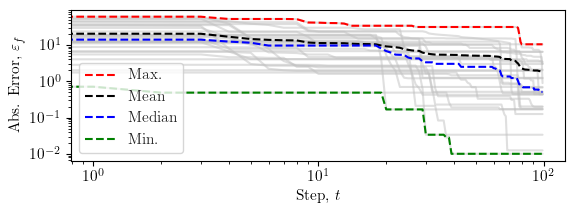

In [7]:
fig, ax = plt.subplots(figsize=(width*0.9, height/1.8))

plt.plot(efp, color="silver", alpha=0.5)
plt.plot(np.max(efp, axis=1), '--', color="red", label=r"Max.")
plt.plot(np.average(efp, axis=1), '--', color="black", label=r"Mean")
plt.plot(np.median(efp, axis=1), '--', color="blue", label=r"Median")
plt.plot(efg, '--', color="green", label=r"Min.")

plt.xlabel(r"Step, $t$")
plt.ylabel(r"Abs. Error, $\varepsilon_f$")

lgd = plt.legend()

plt.xscale("log")
plt.yscale("log")

ax.patch.set_alpha(0)
fig.tight_layout()

save_this(fig, _in="fitness")

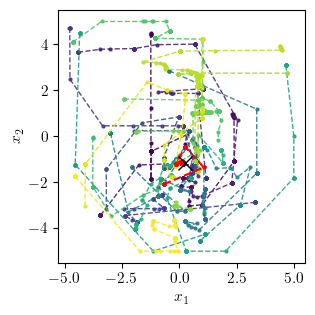

In [8]:
# Plot the agents moving
fig, ax = plt.subplots(figsize=(width/2, width/2))

cmap = plt.get_cmap('viridis', num_agents)
color = cmap(np.linspace(0, 1, num_agents))

for agent, c in enumerate(color):
    plt.plot(positions[:, agent, 0], positions[:,agent, 1], "--o",
             color=c, alpha=0.9, markersize=2, linewidth=1,
             label=f"Agent {agent}")

plt.plot(best_position[:, 0], best_position[:, 1], "--*",
         color="red", markersize=3, label="Best position")
plt.plot(problem.optimum.x[0], problem.optimum.x[1], "x",
         color="black", markersize=10, label="Optimum")

# plt.legend()
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")

ax.patch.set_alpha(0)
fig.tight_layout()

save_this(fig, _in="positions_2d")

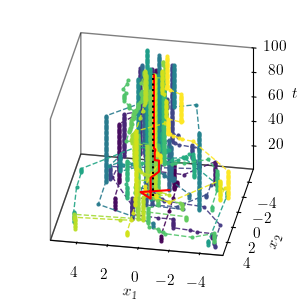

In [9]:
fig = plt.figure(figsize=(width/2, width/2))

ax = fig.add_subplot(111, projection='3d')
ax.set_proj_type('ortho')

cmap = plt.get_cmap('viridis', num_agents)
color = cmap(np.linspace(0, 1, num_agents))

steps = np.arange(optimiser._num_iterations) + 1

for agent, c in enumerate(color):
    ax.plot3D(positions[:, agent, 0], positions[:, agent, 1], steps,
              "--o", color=c, alpha=0.9, markersize=2, linewidth=1,
              label=f"Agent {agent}")

ax.plot3D(best_position[:, 0], best_position[:, 1], steps,
          "-", color="red", markersize=2,  linewidth=1.5,
          label="Best position")
ax.plot3D(problem.optimum.x[0], problem.optimum.x[1], steps,
          ":", color="black", markersize=2,  linewidth=1.5,
          label="Optimum")

for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
    axis.pane.set_edgecolor('black')
    axis.pane.set_linewidth(1.0)

# ax.viewfig, _init(elev=35, azim=135)
ax.view_init(elev=30, azim=100)
# ax.legend()
ax.set_xlabel(r"$x_1$", labelpad=1)
ax.set_ylabel(r"$x_2$", labelpad=1)
ax.set_zlabel(r"$t$", labelpad=0)
ax.set_box_aspect([1, 1, 0.8])

ax.set_zlim(1, num_steps)

# hide background grey color
ax.grid(False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
# ax.zaxis.set_pane_color("grey")

ax.patch.set_alpha(0)
fig.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1)
# fig.tight_layout()

save_this(fig, _in="positions_3d")

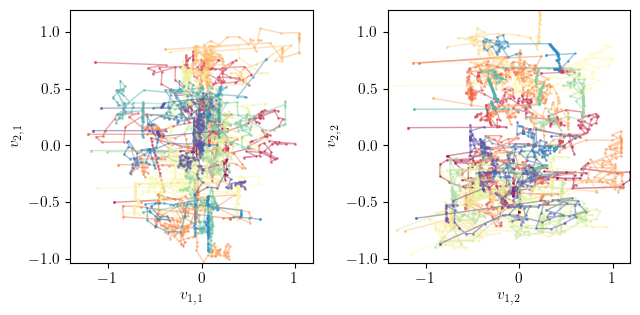

In [10]:
# Plot the phase portrait
fig, axs = plt.subplots(nrows=np.ceil(num_dimensions / 2).astype(int),
                        ncols=2, figsize=(width, width/2))

steps = np.arange(optimiser._num_iterations) + 1
cmap = plt.get_cmap('Spectral', num_agents)
color = cmap(np.linspace(0, 1, num_agents))

for i, ax in enumerate(axs.flatten()):

    for agent, c in enumerate(color):
        ax.plot(v1[agent, :, i], v2[agent, :, i], "-o",
                color=c, alpha=0.5, markersize=1, linewidth=1,
                label=f"Agent {agent}")
        ax.plot(v1[agent, 0, i], v2[agent, 0, i], "-s",
                color=c, alpha=0.5, markersize=1, linewidth=1,
                label=f"Agent {agent}")

    ax.set_xlabel(r"$v_{}$".format("{1," + str(i+1) + "}"))
    ax.set_ylabel(r"$v_{}$".format("{2," + str(i+1) + "}"))

    ax.set_xlim(v1.min(), v1.max())
    ax.set_ylim(v2.min(), v2.max())

    ax.patch.set_alpha(0)

fig.tight_layout()

save_this(fig, _in="portrait_2d")

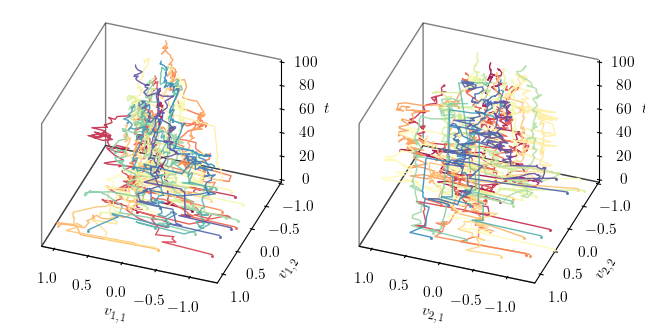

In [11]:
# Plot the phase portrait in 3d
fig = plt.figure(figsize=(width, width/2))

num_rows = np.ceil(num_dimensions / 2).astype(int)
num_cols = 2

axs = [
    fig.add_subplot(
        num_rows, num_cols, i + 1, projection='3d'
    ) for i in range(num_dimensions)
]

steps = np.arange(optimiser._num_iterations) + 1
cmap = plt.get_cmap('Spectral', num_agents)
color = cmap(np.linspace(0, 1, num_agents))

for i, ax in enumerate(axs):
    ax.set_proj_type('ortho')
    ax.set_box_aspect([1, 1, 0.8])
    ax.view_init(elev=35, azim=110)

    for agent, c in enumerate(color):
        ax.plot3D(v1[agent, :, i], v2[agent, :, i], steps, "-",
                  color=c, alpha=0.9,
                  markersize=1, linewidth=1,
                  label=f"Agent {agent}")

        ax.plot3D(v1[agent, 0, i], v2[agent, 0, i], 0, "-s",
                  color=c, alpha=0.9,
                  markersize=1, linewidth=1,
                  label=f"Agent {agent}")

    # ax.set_title(f"Phase portrait {i+1}D")
    # ax.set_aspect("equal")
    ax.set_xlabel(r"$v_{}$".format("{" + str(i+1) + ",1}"))
    ax.set_ylabel(r"$v_{}$".format("{" + str(i+1) + ",2}"))
    ax.set_zlabel(r"$t$", labelpad=0.1)

    ax.set_xlim(v1.min(), v1.max())
    ax.set_ylim(v2.min(), v2.max())

    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis.pane.set_edgecolor('black')
        axis.pane.set_linewidth(1.0)

    ax.grid(False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.patch.set_alpha(0)

fig.tight_layout()

save_this(fig, _in="portrait_3d")

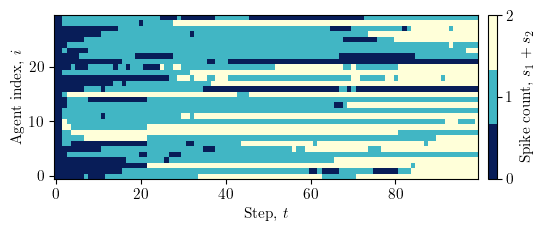

In [12]:
fig, ax = plt.subplots(figsize=(width*0.9, height * 0.6))

spikes_sum = np.sum(spikes, axis=2)  # shape (1000, 30)
# cmap = ListedColormap(['white', 'skyblue', 'navy'])
cmap = plt.get_cmap("YlGnBu_r", 3)
im = ax.imshow(spikes_sum.T, aspect='auto', origin='lower',
               cmap=cmap, vmin=0, vmax=2)

ax.set_xlabel(r"Step, $t$")
ax.set_ylabel(r"Agent index, $i$")
# ax.set_title(r"Spike activity (summed across dimensions)")

cbar = fig.colorbar(im, ax=ax, pad=0.02, ticks=[0, 1, 2])
cbar.set_label(r"Spike count, $s_{1}+s_{2}$")

ax.patch.set_alpha(0)
fig.tight_layout()

save_this(fig, _in="spikes_hm")